## INICIALIZACAO

In [295]:
import sys
sys.path.append('../')

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from joypy import joyplot
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

In [297]:
#get data = 
path ="../data/raw/economatica.xlsx"

In [298]:
plt.style.use("ggplot")

## GET_DATA

In [299]:
df = pd.read_excel(path).dropna()
df.drop(index=df.loc[df["SP500"]== "-"].index,inplace=True)
df = df[df["Data"]>="2009-01-01"].loc[:,["Data","SP500"]].reset_index(drop=True)
df["SP500"] = df["SP500"].astype(float)

## FUNCOES

In [300]:
def criar_precos(media,desvio,variancia,tamanho,preco_inicial):
  #Media, desvio e varaiancia são baseados em um log returns
  #O tamanho se refere a quantidade de dias passados no caso de um backtesting ou dias futuros
  #Adota-se aqui uma distribuição Normal
  
  #Calcular o Brownian Motion 
  NumIntervals = tamanho
  Iterations = 20

  np.random.seed(10)
  SBMotion = norm.ppf(np.random.rand(NumIntervals, Iterations)) 
  
  #Calcular o Drift
  drift = media - 0.5*variancia
  
  #Retorno Diario
  DailyReturns = np.exp(drift+desvio*SBMotion)
  
  #Serie Preços Construcao
  serie_precos = np.zeros_like(DailyReturns)
  
  #Preço Inicial
  serie_precos[0] = preco_inicial
  
  #Construcao da Serie
  for t in range(1,tamanho):
    serie_precos[t] = serie_precos[t-1]*DailyReturns[t]
  
  return serie_precos


In [301]:
def criar_precos2(parametros):
  #Media, desvio e varaiancia são baseados em um log returns
  #O tamanho se refere a quantidade de dias passados no caso de um backtesting ou dias futuros
  #Adota-se aqui uma distribuição Normal
  media,desvio,variancia,tamanho,preco_inicial = parametros
  # parametros são: [media,desvio,variancia,tamanho,preco_inicial]
  
  #Calcular o Brownian Motion 
  NumIntervals = tamanho
  Iterations = 500

  np.random.seed(10)
  SBMotion = norm.ppf(np.random.rand(NumIntervals, Iterations)) 
  
  #Calcular o Drift
  drift = media - 0.5*variancia
  
  #Retorno Diario
  DailyReturns = np.exp(drift+desvio*SBMotion)
  
  #Serie Preços Construcao
  serie_precos = np.zeros_like(DailyReturns)
  
  #Preço Inicial
  serie_precos[0] = preco_inicial
  
  #Construcao da Serie
  for t in range(1,tamanho):
    serie_precos[t] = serie_precos[t-1]*DailyReturns[t]
  
  return serie_precos

In [302]:
def gerar_serie_retornos(serie_preco):
  
  retornos = np.log(serie_preco/serie_preco.shift(1))
  
  return retornos

In [303]:
def gerar_retornos_janelas_rolantes(serie_retornos):
  
  ret_rw = (serie_retornos.rolling(window=252).sum().apply(np.exp)-1).dropna()
  
  return ret_rw

In [304]:
def gerar_retorno_total(serie_retornos):
  
  ret_total = serie_retornos.cumsum().apply(np.exp) -1
  
  return ret_total

In [305]:
def nova_serie(serie_cenario,serie_sp): #Essa nova serie criada é a serie em conjunto com o S&P
  
  tamanho_rows = len(serie_sp) + len(serie_cenario)
  tamanho_columns = len(serie_cenario.T)

  new_series = np.zeros([tamanho_columns,tamanho_rows])
  i = 0
  for series in serie_cenario.T:
    x = np.append(np.array(serie_sp),series).T
    new_series[i] = x
    i +=1
    
  new_series = new_series.T
    
  return new_series

## PROCESSAMENTO

#Comportamento do Indice

In [306]:
retornos_sp = np.log(df["SP500"]/df["SP500"].shift(1))
serie_precos_sp = df["SP500"]

#Backtesting

In [307]:
#Premissas 
media = 0.08/252
desvio = retornos_sp.std()
variancia = retornos_sp.var()
preco_inicial = df["SP500"].iloc[0]
tamanho = len(df["SP500"])

In [308]:
serie_precos_backtesting = criar_precos(media,desvio,variancia,tamanho,preco_inicial)

#Definindo os parametros

In [309]:
def gerar_parametros(retornos_sp,serie_precos_sp): #
  
  #Constantes
  preco_inicial = serie_precos_sp.iloc[1]
  preco_final = serie_precos_sp.iloc[-1]
  desvio = retornos_sp.std()
  variancia = retornos_sp.var()
  tamanho = 252*7
  
  #Paramatro 1: Considera a media historica S&P como input de retorno
  media = retornos_sp.mean()
  #Parametro 2: Media de 9% a.a como input de retorno
  media2 = 0.09/252
  #Parametro 3: Media de 12% a.a como input de retorno
  media3 = 0.12/252
  #Parametro 4: Media de 15% a.a como input de retorno
  media4 = 0.15/252
  
  p1 = (media,desvio,variancia,tamanho,preco_final)
  p2 = (media2,desvio,variancia,tamanho,preco_final)
  p3 = (media3,desvio,variancia,tamanho,preco_final)
  p4 = (media4,desvio,variancia,tamanho,preco_final)
  parametros = [p1,p2,p3,p4]
  
  return parametros
  
  

In [310]:
parametros = gerar_parametros(retornos_sp,serie_precos_sp)

#Analise de Cenarios

In [311]:
#Serie de Preços Cenario 1

series_c1 = criar_precos2(parametros[0])
series_c2 = criar_precos2(parametros[1])
series_c3 = criar_precos2(parametros[2])
series_c4 = criar_precos2(parametros[3])

In [312]:
#Criando Novas series: Juncao serie simulada com serie historica real
#Objetiva analisar a janela de 20 Anos

new_series_c1 = nova_serie(series_c1,serie_precos_sp)
new_series_c2 = nova_serie(series_c2,serie_precos_sp)
new_series_c3 = nova_serie(series_c3,serie_precos_sp)
new_series_c4 = nova_serie(series_c4,serie_precos_sp)

In [313]:
cenarios = [new_series_c1,new_series_c2,new_series_c3,new_series_c4]
df_precos_cenarios =[]
for cenario in cenarios:
  df_precos_cenarios.append(pd.DataFrame(cenario))

#Analise Retornos

In [314]:
df_ret_cenarios = []
for dataframe in df_precos_cenarios:
  df_ret_cenarios.append(gerar_serie_retornos(dataframe))
  

#Analise Retorno Em Janelas Rolantes

In [316]:
df_ret_rw_cenarios =[]

for dataframe in df_ret_cenarios:
  df_ret_rw_cenarios.append(gerar_retornos_janelas_rolantes(dataframe))
  
df_ret_rw_hist = gerar_retornos_janelas_rolantes(retornos_sp)

#Analise Retorno Total

In [317]:
df_ret_total_cenarios = []

for dataframe in df_ret_cenarios:
  
  df_ret_total_cenarios.append(gerar_retorno_total(dataframe))

In [318]:
df_ret_total_hist = gerar_retorno_total(retornos_sp)

#Analise Drawdown

In [371]:
def calculate_drawdown(daily_returns):
  
  index = 1000*daily_returns.cumsum().apply(np.exp)
  picos = index.cummax()
  drawdown = ((index-picos)/picos)
  
  return drawdown

In [372]:
df_drawdown_cenarios = []
for dataframe in df_ret_cenarios:
  df_drawdown_cenarios.append(calculate_drawdown(dataframe))

In [384]:
medias_drawdown = []

for dataframe in df_drawdown_cenarios:
  medias_drawdown.append(dataframe.describe().iloc[3].mean())

In [388]:
drawdown_sp = calculate_drawdown(retornos_sp).min()

In [389]:
drawdown_sp

-0.33924959024260615

In [385]:
medias_drawdown

[-0.3786473475176425,
 -0.38726090297812343,
 -0.3698352023510342,
 -0.3583736930107515]

In [383]:
dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,...,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000
mean,-0.077281,-0.052246,-0.055840,-0.054434,-0.077408,-0.168754,-0.064092,-0.104104,-0.067535,-0.082978,...,-0.054461,-0.058955,-0.069373,-0.072217,-0.040282,-0.052867,-0.047476,-0.105588,-0.054975,-0.083016
std,0.079669,0.058170,0.059227,0.057317,0.083566,0.200653,0.071171,0.121025,0.071746,0.092589,...,0.057409,0.070304,0.069861,0.079724,0.049846,0.058725,0.050908,0.107727,0.057865,0.086213
min,-0.339250,-0.339250,-0.339250,-0.339250,-0.349157,-0.656870,-0.339250,-0.507461,-0.339250,-0.339250,...,-0.339250,-0.339250,-0.339250,-0.339250,-0.339250,-0.339250,-0.339250,-0.387167,-0.339250,-0.342154
25%,-0.131155,-0.079823,-0.086691,-0.090221,-0.129033,-0.332330,-0.105033,-0.171790,-0.106146,-0.135876,...,-0.088281,-0.083544,-0.118652,-0.116961,-0.056083,-0.084654,-0.072384,-0.199635,-0.089925,-0.144887
50%,-0.046454,-0.031940,-0.035146,-0.033499,-0.043203,-0.061675,-0.035162,-0.050193,-0.040560,-0.041301,...,-0.033493,-0.030397,-0.044612,-0.038089,-0.022346,-0.029628,-0.031425,-0.058540,-0.033840,-0.047914
75%,-0.009331,-0.006352,-0.007517,-0.006803,-0.008563,-0.010055,-0.007493,-0.009342,-0.008536,-0.008077,...,-0.007107,-0.006285,-0.009166,-0.007620,-0.004555,-0.006018,-0.006914,-0.009789,-0.006346,-0.009151
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [381]:
medias_drawdown

[0     -0.108301
 1     -0.055495
 2     -0.061213
 3     -0.061102
 4     -0.097514
          ...   
 495   -0.056882
 496   -0.051456
 497   -0.133212
 498   -0.063058
 499   -0.095381
 Length: 500, dtype: float64,
 0     -0.119677
 1     -0.056753
 2     -0.063932
 3     -0.063671
 4     -0.103045
          ...   
 495   -0.058411
 496   -0.052806
 497   -0.143299
 498   -0.066101
 499   -0.101750
 Length: 500, dtype: float64,
 0     -0.095396
 1     -0.054294
 2     -0.059039
 3     -0.058454
 4     -0.090775
          ...   
 495   -0.055208
 496   -0.049986
 497   -0.120554
 498   -0.059791
 499   -0.090593
 Length: 500, dtype: float64,
 0     -0.077281
 1     -0.052246
 2     -0.055840
 3     -0.054434
 4     -0.077408
          ...   
 495   -0.052867
 496   -0.047476
 497   -0.105588
 498   -0.054975
 499   -0.083016
 Length: 500, dtype: float64]

In [378]:
medias

[0.1176, 0.1127, 0.1235, 0.1346, 0.12378268626549603]

#Analise Retorno Medio Janelas Rolantes

In [335]:
#Analise Medias Retorno Janela Rolante
medias_cenarios= []
mediana_cenarios = []
for dataframe in df_ret_rw_cenarios:
  medias_cenarios.append(round(dataframe.describe().iloc[1].mean(),4))
  mediana_cenarios.append(round(dataframe.describe().iloc[1].median(),4))

In [344]:
media_original = df_ret_rw_hist.mean()
mediana_original = df_ret_rw_hist.median()

In [345]:
medias  = medias_cenarios.copy()
medias.append(media_original)
medianas = mediana_cenarios.copy()
medianas.append(mediana_original)

#Analise Retorno Medio CAGR 

In [361]:
def gerar_cagr(df,tamanho):
  
  CAGR = (df.iloc[-1]/df.iloc[0])**(1/tamanho) -1 
  
  return CAGR

In [362]:
media_cagr_cenarios = []
mediana_cagr_cenarios = []
for dataframe in df_precos_cenarios:
    media_cagr_cenarios.append(gerar_cagr(dataframe,20).mean())
    mediana_cagr_cenarios.append(gerar_cagr(dataframe,20).median())

In [363]:
cagr_sp = gerar_cagr(serie_precos_sp,13)

media_cagrs = media_cagr_cenarios.copy()
media_cagrs.append(cagr_sp)

## VISUALIZATION

### FUNCOES

In [ ]:
def view_backtesting(serie_precos,df_sp500):
  
  fig,axes = plt.subplots(1,2,figsize=(15,5))

  axes[0].plot(
      df_sp500["Data"],
      serie_precos
  );

  axes[1].plot(
      serie_precos
  );
  axes[0].set(xlabel="Periodo",ylabel="Preço Índice",title="S&P500 com 20 Cenários Possíveis (Backtesting 2009-2023)")
  axes[1].plot(df_sp500.iloc[:,1],'k*')
  axes[1].set(xlabel="Periodo",ylabel="Preço Índice",title="S&P500 com 20 Cenários Possíveis Backtesting 2009-2023 e S&P500 Real");
  plt.tight_layout()
  
  return fig

In [ ]:
def view_comportamento_indice(df_indice,retornos):
  
  fig,axes = plt.subplots(1,2,figsize=(15,5))

  df_indice.plot(
      kind="line",
      x="Data",
      y="SP500",
      xlabel="Periodo",
      ylabel="Preço",
      legend=False,
      title="Evolução Preço do Indice",
      ax=axes[0]
  )

  axes[1].plot(
    df_indice["Data"],
    retornos
  )
  axes[1].set(xlabel="Periodo",ylabel="Variação Diaria",title="Retorno Indice")
  fig.tight_layout;
  
  return fig

  

In [ ]:
def view_forecasting(serie_preco1,serie_preco2):

  # start_date = '2023-01-13'
  # freq = 'D'
  # periods = tamanho

  # period = pd.period_range(start=start_date, freq=freq, periods=periods)
  fig,axes = plt.subplots(1,2,figsize=(15,5))

  axes[0].plot(
      serie_preco1
  );

  axes[1].plot(
      serie_preco2
  );

  axes[0].set(xlabel="Periodo",ylabel="Preço Índice",title="S&P500 com 20 Cenários Possíveis (Forecast 2023-2030) Media 9% a.a")
  axes[1].set(xlabel="Periodo",ylabel="Preço Índice",title="S&P500 com 20 Cenários Possíveis (Forecast 2023-2030) Media 12% a.a")
  plt.tight_layout()
  
  return fig



In [207]:
def view_return_total_forecastig(df_total_return):

  # Create a figure with 4 rows and 5 columns
  fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15,10))

  # Loop through each column and plot it in a subplot
  for i, col in enumerate(df_total_return.columns):
      ax = axs[i // 5, i % 5]
      ax.plot(df_total_return[col])
      ax.set_title(col)
      ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))

  # Adjust the spacing between subplots and show the plot
  plt.suptitle("Analise Retorno Total Simulacao Media 9% a.a")
  plt.tight_layout()
  plt.show()
  return fig

In [ ]:
# def view_medias_cenaris(lista_ret_total,lista_ret_rw): #Ele recebe uma lista com as medias dos cenarios
  
#   fig,axes = plt.subplots(1,2,figsize=(18,5))
#   plt.style.use("ggplot")
#   axes[0].bar("Simulacao Retorno Medio 9% a.a",lista_ret_total[0])
#   axes[0].bar("Simulacao Retorno Medio 12% a.a",lista_ret_total)
#   axes[0].bar("Retorno S&P500 Real",media_acumulado_original)
#   axes[0].yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
#   axes[0].set(title="Mediana Retorno Total Acumulado por Simulação - 500 Cenarios",ylabel="Retorno (%)",xlabel="Cenarios")

#   axes[1].bar("Simulacao Retorno Medio 9% a.a",media_rw_1)
#   axes[1].bar("Simulacao Retorno Medio 12% a.a",media_rw_2)
#   axes[1].bar("Retorno S&P500 Real",media_original)
#   axes[1].yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
#   axes[1].set(title="Mediana Retorno em Janelas Rolantes de 12M - 500 Cenarios",ylabel="Retorno (%)",xlabel="Cenarios")
#   plt.tight_layout();


In [ ]:
### ANALISE QUARTIS
# #Creating a copy ret_simu_anual 
# teste = ret_simu1_anual.copy()
# teste["S&P500"] = ret_original_anual

# nome_colunas = []
# for i in range(0,20,1):
#     nome_colunas.append(f"Simu_{ret_simu1_anual.columns[i]}")
# nome_colunas.append("S&P500")
# teste.columns = nome_colunas

# fig,ax = plt.subplots(figsize=(15,5))
# teste.boxplot(ax=ax)
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
# ax.set(title="Analise Quartis Janelas Rolantes de 12M Simulacao 9% a.a",ylabel="Retorno (%)",xlabel="Cenarios")
# plt.tight_layout()
# plt.show();


### Comportamento do Indice

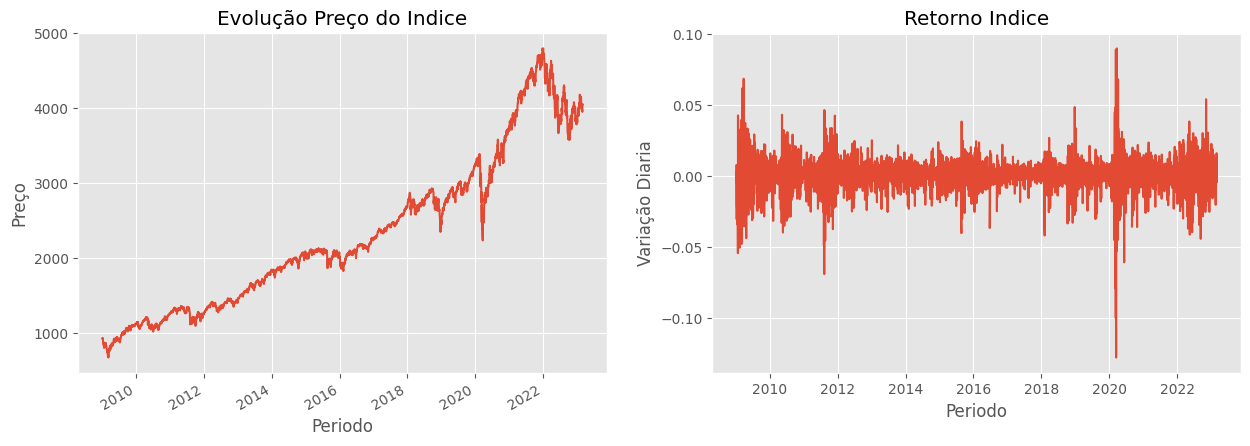

In [ ]:
fig1 = view_comportamento_indice(df,retornos_sp)

### Backtesting

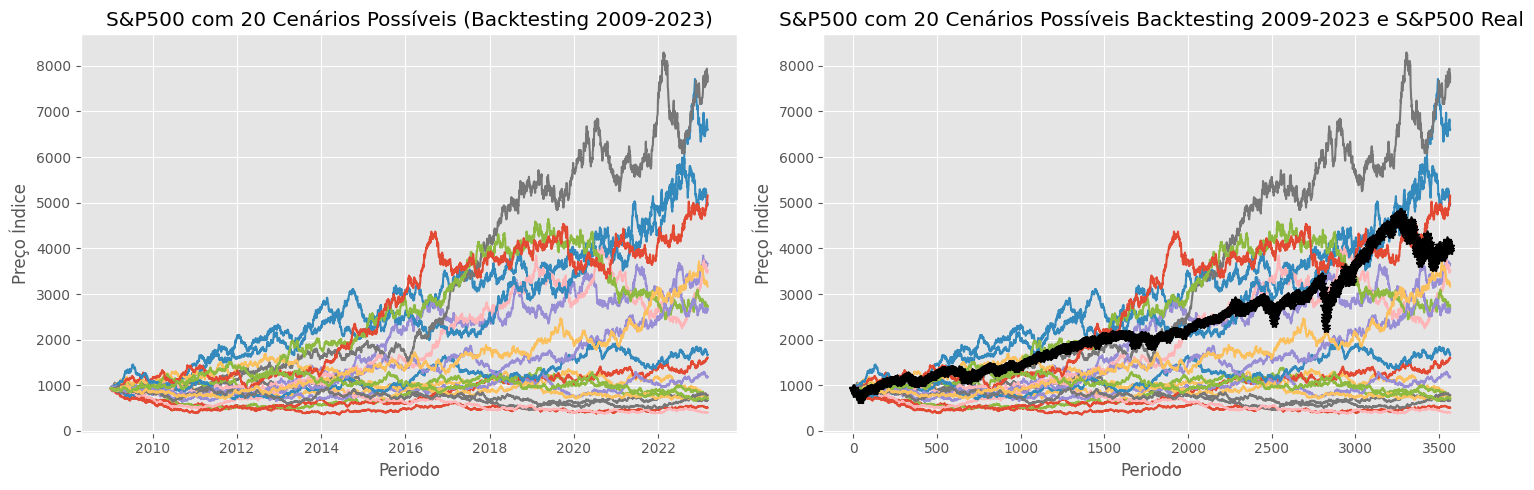

In [ ]:
fig2 = view_backtesting(serie_precos_backtesting,df)

### Dinamica Evolução Preços: Parte Historica e Forecasting

In [187]:
def view_forecasting(dataframes,titulos_medias,label_y,label_x):

  fig, axes = plt.subplots(2,2,figsize=(25,15))

  dataframes[0].plot(ax=axes[0][0],legend=False)
  dataframes[1].plot(ax=axes[0][1],legend=False)
  dataframes[2].plot(ax=axes[1][0],legend=False)
  dataframes[3].plot(ax=axes[1][1],legend=False)

  axes[0][0].set(title=titulos_medias[0],ylabel=label_y,xlabel=label_x)
  axes[0][1].set(title=titulos_medias[1],ylabel=label_y,xlabel=label_x)
  axes[1][0].set(title=titulos_medias[2],ylabel=label_y,xlabel=label_x)
  axes[1][1].set(title=titulos_medias[3],ylabel=label_y,xlabel=label_x)

  plt.tight_layout();
  
  return fig;

### Medias Janelas Rolantes

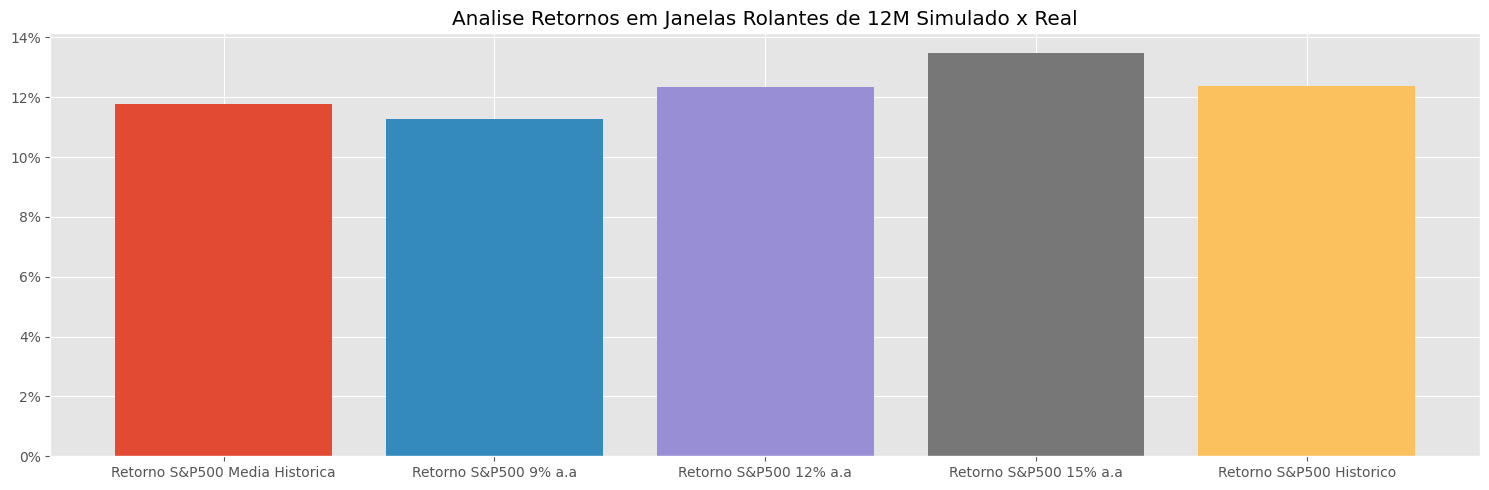

In [366]:
#medias
labels = ["Retorno S&P500 Media Historica",
          "Retorno S&P500 9% a.a",
          "Retorno S&P500 12% a.a",
          "Retorno S&P500 15% a.a",
          "Retorno S&P500 Historico"] 
titulo = "Analise Retornos em Janelas Rolantes de 12M Simulado x Real"

labels2 = ["CAGR Medio S&P500 Media Historica",
          "CAGR Medio S&P500 9% a.a",
          "CAGR Medio S&P500 12% a.a",
          "CAGR Medio S&P500 15% a.a",
          "CAGR S&P500 Historico"] 
fig,ax = plt.subplots(1,1,figsize=(15,5))

ax.bar(labels[0],medias[0])
ax.bar(labels[1],medias[1])
ax.bar(labels[2],medias[2])
ax.bar(labels[3],medias[3])
ax.bar(labels[4],medias[4])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
ax.set(title=titulo)
plt.tight_layout();

### Medias CAGRS

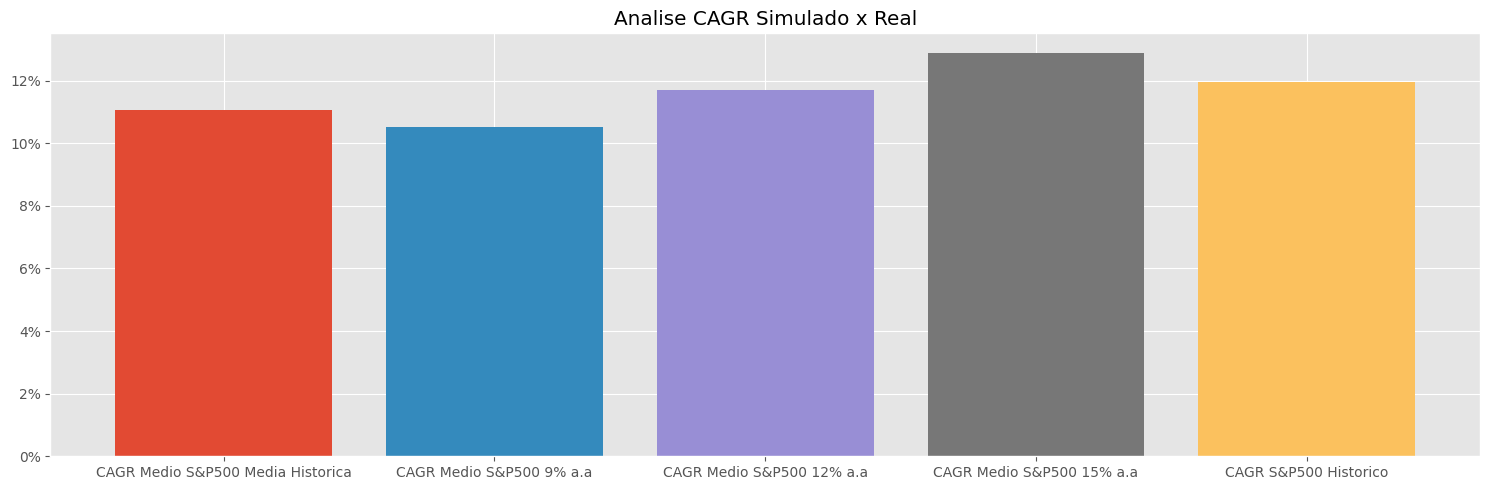

In [370]:
titulo = "Analise CAGR Simulado x Real"

labels2 = ["CAGR Medio S&P500 Media Historica",
          "CAGR Medio S&P500 9% a.a",
          "CAGR Medio S&P500 12% a.a",
          "CAGR Medio S&P500 15% a.a",
          "CAGR S&P500 Historico"]

fig,ax = plt.subplots(1,1,figsize=(15,5))

ax.bar(labels2[0],media_cagrs[0])
ax.bar(labels2[1],media_cagrs[1])
ax.bar(labels2[2],media_cagrs[2])
ax.bar(labels2[3],media_cagrs[3])
ax.bar(labels2[4],media_cagrs[4])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:00.0000%}'))
ax.set(title=titulo)
plt.tight_layout();

In [236]:
# dataframes_teste = []
# for dataframe in dataframes_cenarios:
#   dataframes_teste.append(dataframe.iloc[:,:20])

# label_y = "Preço Indice"
# label_x = "Periodo avaliado entre 2009-2030"
# titulos_medias = ["Retorno S&P500 Media Historica",
#           "Retorno S&P500 9% a.a",
#           "Retorno S&P500 12% a.a",
#           "Retorno S&P500 15% a.a"]          
# fig3 = view_forecasting(dataframes_cenarios,titulos_medias,label_y,label_x)